# Module 6: CFA
# Use Case: Credit Risk - Identifying Bad Credit Risks
# ===========================================

In this example, we aim to predict bad consumer credits, and we develop a classification model for this purpose, driven by loan and debtor attributes. We would use this model to accept or reject a customer’s business.

Dataset: Credit risk https://datahub.io/machine-learning/credit-g
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [122]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# Package for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# package for timing runtime
import time

# package for navigating the operating system
import os

# Utilities: Governance and Fairness Functions

First we will declare and introduce the functions we will be using to implement the Governance Framework, and principles of Fairness in our process.




## Governance Framework and Utility Function Overview

A Governance framework ensures models in an organisation achieve all their key stakeholder requirements satisfactorily, and in a safe, verifiable way. In this section we introduce functions we will use lter in thje use-case to control and monitor model development process to ensure our aims are achieved.

Manys steps in a Governance Framework are qualitative, requiring professionals to assess, specify, approve or reject stages in model development. However, quantitative tools can be a powerful utility, allowing professionals to control and monitor a process, and reach judgements about model design, stability, and efficacy. 

We discuss the 5 stages of model development and the utility functions that can be used to support the Governance Framework:

#### Stage1: Business Analysis
We first define our stakeholder KPIs, which should be systematically defined. We introduce example functions that go some way to representing stakeholder KPIs, with visualizations, statistical tests and checks where appropriate. 

#### Stage2: Data Process
Exploratory data analysis goes some way to examining the quality and nature of the data, looking at distributions, correlations, imbalances in the data. We use some utility functions to support this.

#### Stage3: Model Design and Development
From a governance point of view, model design and development is more qualitative, and requires good practice, statitically and in terms of the code implementation. Good commenting is essential, sanity checking of input and return values is advised, and in Python clear parameter declaration and control of source code, and code versions is essential too. 
We also need to ensure that the outcomes of our model are fair to different population groups, as well as having a good precision to protect the business from loan losses. We will introduce functions to ensure fairness.

#### Stage4: Model Deployment
Model deployment involes multiple stages of testing and authorization. We propose a challenger model to conduct part of this process, which is also used in the monitoring and reporting stage also.

#### Stage5: Monitoring/Reporting
During live running of the models, monitoring of data drift is essential, and for additional safety a challenger model can be run in parallel to the live model, to ensure the live model is functioning well with respect to stakeholder KPIs.


## Stage1 Business Analysts Governance Utilities
In Stage1, Business Analysis, for the Governance Framework we need to establish the risk level of the model - in this case high, including its impact on the organisation and technology, regulatory risk, and so on. As the model will be used to make credit decisions which will expose tyhe business to losses, regulatory risk and more, this is a high risk application requiring higher levels of Governance scrutiny. 
We also need to establish who the stakeholders are, and specify analytics to verify that we are attaining good performance on each stakeholder's key performance indicators (KPI). (There is also the communication of how our model has achieved these KPIs which we will address towards the end of the workflow).

In this section we cover the utility functions that will be needed to monitor (and enforce) stakeholder KPIs.


### Stakeholder KPIs

#### Stakeholder KPIs: Customer
We assume for this case study that the customer KPI is whether they achieve they achieve a positive credit decision, and whether this is fair (see below). It is also important to explain to customers why they did not achieve a positive credit decision too.


#### Stakeholder KPIs: Compliance and Regulatory
Regulatory KPIs include fairness (similar to a customer's KPI above), and also a reasonable level of precision, or risk from loan losses(simlar to the lenders KPIs). 
Fairness in this context is accuracy, the number of false negatives, of people erroneously refused credit. Ensuring accuracy is similar across different groups is essential to ensuring the model is fair to all.



#### Stakeholder KPIs: Analyst and technical

In [123]:
import sklearn.metrics as metrics

# Performance metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Analyst KPI: ROC Curve, f1, precision and accuracy of y_hat from a classifier
# Compute micro-average ROC curve and ROC area
def kpi_review_analyst(mdl: object,
                       X: np.array, 
                       y: np.array,
                       y_hat: np.array) -> (float, float, float):
   
  '''
  Args:
       mdl: sklearn classifier model object
       X: X variables, columns are features, rows are instances
       y: actual target variable {1,0}
       y_hat: prediction of target
       
    Returns:
       f1, prec, rec: F1 score, precision, recall.
       
    Author:
       Dan Philps
    '''

  #sanity
  if X.shape[0] != y_test.shape[0]:
    raise TypeError('Bad parameter: X.shape[0] != y_test.shape[0]')
  if y.shape[0] != y_hat.shape[0]:
    raise TypeError('Bad parameter: y_test.shape[0] != y_test_hat.shape[0]')
  if (y.dtype != y_hat.dtype):
    raise TypeError('Bad parameter: y_test.dtypes != y_test_hat.dtypes')

  # F1, precision, recall...  
  prec = precision_score(y_true=y[:], y_pred=y_hat[:])
  rec = recall_score(y_true=y[:], y_pred=y_hat[:])
  f1 = f1_score(y_true=y[:], y_pred=y_hat[:])

  print(prec)

  # ROC Curve
  metrics.plot_roc_curve(mdl, X, y) 
  fpr, tpr, thresholds = metrics.roc_curve(y, y_hat)
  plt.title('Credit Decisions ROC Curve')
  plt.show()

  return f1, prec, rec

## Stage 2 Data Process Governance Utilities

Exploratory data analysis should be thorough enough to reveal sytrengthes and weaknesses of the data. We can examin distributions and correlations, but we should explicitly check for imbalances in the dataset, particulalry the y variable.

In [124]:
# Check for imbalances, charts pie of imbalances in the y variable 
# wrapped as a func as we will use it a few times..
def imbalanced_y_check(y: pd.Series) -> bool:  
  '''
    Args:
        y: Dataframe of only the y variable
       
    Returns:
       bool: True if imbalanced, False, if not imbalanced.

    Author: 
      Dan Philps
    '''

  print('Dataset Balanced?')
  print(y.value_counts())

  # Convert to df...
  df_y = pd.DataFrame(y)
  class_col = y.name
  df_y.groupby(df_y[class_col]).size().plot(kind='pie', y=class_col, label = "Type",  autopct='%1.1f%%')

  #Rule of thumb... highest frequency class < 70% of observations
  imbalanced = False
  perc_split = df_y.value_counts() / df_y.shape[0]
  if np.max(perc_split) >= 0.7:
    print('Imbalanced y variable!')
    imbalanced = True
  
  return imbalanced

## Stage 3 Model Design and Development Governance Utilities

### Stage3a: Fairness

For classifiers such as this model, we are looking for a probability of default threshold that is acceptable to us as the lender. If a customer has a probability of default above this threshold, we would reject the application, below and we would accept the application. By adjusting this probability of default threshold value, the false positive / false negative outputs from the model change, and need to be appropriate for the lenders capital buffer, liquidity, and risk tolerance. 
At the same time as the precision of the model is appropriate, we also need to ensure the model is fair at that level of precision (note that the false positive and false negative rates will change at different threshold values).
One exercise to ensure fair models is to appropriately select a threshold value such that the model has similar accuracy across (ie a false negative rate) between protected and priviledged classes, and is similarly accurate for all underlying population groups. It is normally seen that there is a trade-off between accuracy and fairness when using machine learning models to make policy decisions and fairness bias should be carefully eliminated.

These utility functions will be used to monitor fairness across different classes in the dataset, to ensure a similar level of accuracy in each group.

In [125]:
from sklearn.metrics import confusion_matrix
def x_metrics(true_label, predicted_label):
    #This module computes the confusion matrix columns
    TN, FP, FN, TP = confusion_matrix(true_label, predicted_label, labels = [0,1]).ravel()
    return TN, FP, FN, TP

def trainModel(X_train, y_train):
    rf1 = RandomForestClassifier(max_depth=5,random_state=0)
    rf1.fit(X_train,y_train)
    return rf1

def predictModel(model, X_test, threshold=0.5):
    y_pred_proba = model.predict_proba(X_test)
    return (y_pred_proba[:,0] < threshold).astype('int')

def getFairnessRatios(y_test, y_pred):
    TN, FP, FN, TP = x_metrics(y_test, y_pred)
    accuracy = (TP + TN)/(TP+TN+FP+FN)
    fnr = FN/(FN+TP)
    fdr = FP/(FP+TP)
    fpr = FP/(FP+TN)
    npv = TN/(TN+FN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    return pd.Series({'Stats': '', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'fnr': fnr, 'fdr': fdr, 'fpr': fpr, 'npv': npv})

In [126]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import math

# Fairness: run the model on different groups, and get precision, accuracy, f1 and so on, for each model run/group
# Calcluates these stats for the predictions of a trained model (mod) for each category 
# in a given column (category_col_name) in the data set (X_test). 
def fairness_stats_get (mod: object, 
                      X_test: pd.DataFrame, 
                      y_test: pd.DataFrame, 
                      X_test_category_col: pd.DataFrame,
                      y_approval_threshold: float = 0.5) -> pd.DataFrame:
   
  '''    
  Args:
      mod: sklearn model, trained without the category_col_name, and ready to test for biases.
      X_test: X data, including the category_col_name you want to examine 
      y_test: y data, including the category_col_name you want to examine
      X_test_category_col: column - corresponding to X_test and y_test in which categories are contained we want to test for fairness
      y_approval_threshold: We are forevcasting the probability of default, this is the threashold over which we assume credit will be offered
      
  Returns:
      df_stats: record of the accuracy (etc) of the model on each category. Examine this for fairness...

  Author:
    Madhu Nagarajan
  '''
  #Sanity
  if mod is None:
    raise TypeError('mod has not been instantiated or trained')
  if X_test.shape[0] != y_test.shape[0]:
    raise TypeError('X_test.shape[0] != y_test.shape[0]')
  if X_test.shape[0] != X_test_category_col.shape[0]:
    raise TypeError('X_test.shape[0] != X_test_category_col.shape[0]:')
  if (y_approval_threshold < 0) | (y_approval_threshold > 1):
    raise TypeError('(approval_threshold < 0) | (approval_threshold > 1)')

  # Ini
  df_stats = pd.DataFrame()
  stats_cols = []

  # Get categories in our test column
  categories = X_test_category_col.unique()

  # Loop through each of the categories in the category_col
  # Eg male (=0) and female (=1)
  # test acccuracy/precision/recall for each cat
  for cat in categories:
      #Filter on the cat
      cat_rows = (X_test_category_col == cat)
      #X...    
      X_test_cat = X_test.loc[cat_rows]
      #y...
      y_test_cat = y_test.loc[cat_rows]
      
      # Predict the probability of default, and decide who to offer credit to
      y_test_cat_hat_pred_proba = mod.predict_proba(X_test_cat)
      y_test_cat_hat = (y_test_cat_hat_pred_proba[:,0] < y_approval_threshold).astype('int')

      # Calc and record fairness analytics for each cat, record in df_stats
      TN, FP, FN, TP = confusion_matrix(y_test_cat, y_test_cat_hat, labels = [0,1]).ravel()
      fnr = FN/(FN+TP)
      fdr = FP/(FP+TP)
      fpr = FP/(FP+TN)
      npv = TN/(TN+FN)

      cat_row = pd.Series({'cat': cat,
                          'cat_proportion': np.divide(float(X_test_cat.shape[0]),float(X_test.shape[0])), 
                          'accuracy': accuracy_score(y_true=y_test_cat, y_pred=y_test_cat_hat),  
                          'precision': precision_score(y_true=y_test_cat, y_pred=y_test_cat_hat), 
                          'recall': recall_score(y_true=y_test_cat, y_pred=y_test_cat_hat), 
                          'fnr': fnr, 'fdr': fdr, 'fpr': fpr, 'npv': npv})

      # Build record of accuracy and so on, of each category in the category_col
      df_stats = pd.concat([df_stats, cat_row], axis=1)
      stats_cols.append(cat)
  
  # Set up df_stats with column names and an index
  df_stats = df_stats.transpose()
  df_stats.columns = cat_row.index
  df_stats = df_stats.set_index(df_stats['cat'])
  df_stats = df_stats.drop('cat', axis=1)

  return df_stats


In [127]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
"""
#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#****************************
X_test_gender = X_test['gender']
# Remember to remove protected columns before training
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

df_stats = fairness_stats_get(max_mdl, X_test=X_test, y_test=y_test, X_test_category_col=X_test_gender)
"""
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



"\n#Split first to avoid data-snooping\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)\n\n#****************************\nX_test_gender = X_test['gender']\n# Remember to remove protected columns before training\nX_train = X_train.drop(protected_cols, axis=1)\nX_test = X_test.drop(protected_cols, axis=1)\n#****************************\n\ndf_stats = fairness_stats_get(max_mdl, X_test=X_test, y_test=y_test, X_test_category_col=X_test_gender)\n"

In [128]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
"""
import matplotlib.pyplot as plt

#Added by Madhu
#def fairness_test(df_stats: pd.DataFrame, 
#                 compare_metrics: str = ['precision'], 
#                 critical_fairness_threshold: float = 0.2,
#                 y_approval_threshold: float = 0.5):

compare_metrics = ['precision'], 
critical_fairness_threshold = 0.2,
y_approval_threshold = 0.5

fig, axs = plt.subplots(5)

# Majority category...
x_val = [2, 1]
majority_cat = df_stats[(df_stats['cat_proportion'] == df_stats['cat_proportion'].max())].index[0]

# Now plot the fairness charts
i = 0
for metric in compare_metrics: 
    #Get majority category stat
    maj_range = df_stats.loc[df_stats.index == majority_cat, metric].astype('float64').values[0]
    
    y_val = df_stats[metric].values.tolist()

    axs[0].bar(x_val, y_val)
    axs[0].set_title( "At Credit Approval Threshold " + str(y_approval_threshold))
    #axs[i, 0].set_ylim(0,1)
    #axs[i, 0].set_ylabel(metric)
    #axs[i, 0].axhline(y=maj_range*(1-critical_fairness_threshold),color='red')
    #axs[i, 0].axhline(y=maj_range,color='green')
    #axs[i, 0].axhline(y=maj_range*(1+critical_fairness_threshold),color='red')
    plt.subplots_adjust(hspace=1)
    i += 1
fig.tight_layout()

#fairness_test(df_stats=df_stats)

"""
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

'\nimport matplotlib.pyplot as plt\n\n#Added by Madhu\n#def fairness_test(df_stats: pd.DataFrame, \n#                 compare_metrics: str = [\'precision\'], \n#                 critical_fairness_threshold: float = 0.2,\n#                 y_approval_threshold: float = 0.5):\n\ncompare_metrics = [\'precision\'], \ncritical_fairness_threshold = 0.2,\ny_approval_threshold = 0.5\n\nfig, axs = plt.subplots(5)\n\n# Majority category...\nx_val = [2, 1]\nmajority_cat = df_stats[(df_stats[\'cat_proportion\'] == df_stats[\'cat_proportion\'].max())].index[0]\n\n# Now plot the fairness charts\ni = 0\nfor metric in compare_metrics: \n    #Get majority category stat\n    maj_range = df_stats.loc[df_stats.index == majority_cat, metric].astype(\'float64\').values[0]\n    \n    y_val = df_stats[metric].values.tolist()\n\n    axs[0].bar(x_val, y_val)\n    axs[0].set_title( "At Credit Approval Threshold " + str(y_approval_threshold))\n    #axs[i, 0].set_ylim(0,1)\n    #axs[i, 0].set_ylabel(metric)\n    #

## Stage 4 Model Deployment Governance Utilities

### Stage4a Challenger Models

The following function, trains a challenger model using sklearn classifiers, and can be used to challenge our live model by comparing KPIs between our live  and challenger models.


In [129]:
from sklearn.ensemble import VotingClassifier

# Create a challenger model
# requires a list of ready trained models (all_mdls) and corresponding descrtiptions 
# (all_mdls_desc) and performance (all_mdls_prec). Ensembled the better performers
# and uses the resulting model as a challenger 
def challenger_ensemble_run(all_mdls: list, 
                  all_mdls_desc: list,
                  all_mdls_prec: list,
                  X_train: pd.DataFrame,
                  y_train: pd.DataFrame, 
                  X_test: pd.DataFrame) -> (np.array, object):
  '''
  Args:
    all_mdls: a list of sklearn classifiers, trained and ready to go.
    all_mdls_desc: list of description of the above model objects (elements corresponding to the above also)       
    all_mdls_prec: list of out-of-sample prec scores for each of the above model objects, used to elmininate the poor performers from the challenger (elements corresponding to the above also)       
    X_train: DataFrame with training data for classifier, columns are features, rows are instances
    X_test: Test data matching above shape
    y_train: training data target variable {1,0}, instances are rows.
    y_test: test data target variable {1,0}, instances are rows.
      
  Returns:
      y_hat: numpy array containing predictions from the challenger
      object: sklearn model object containing the challenger model.
      
  Author:
      Dan Philps
  '''

  #Sanity
  if X_train.shape[0] != y_train.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
  if X_test.shape[1] != X_train.shape[1]:
    raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')

  # Only use classifiers that have generated an above median F1 score out of sample.
  min_prec_to_use = np.median(all_mdls_prec)
  
  # Prepare our models for ensembling
  challenger_models = []
  for i in range(0, all_mdls_desc.__len__()):
    if all_mdls_prec[i] > min_prec_to_use:
      challenger_models.append((all_mdls_desc[i], all_mdls[i]))

  # Instantiate ...
  vc = VotingClassifier(estimators=challenger_models, voting='soft')

  # Fit on the training data to train your live model... 
  challenger_mdl = vc.fit(X_train.values, y_train.values)

  # Challenge! Compare the results
  y_hat = challenger_mdl.predict(X_test)
  
  return y_hat, challenger_mdl


## Stage5 Model Monitoring and Reporting Governance Utilities


### Stage5a: Data drift monitoring
After our model is released into the live environment, we need to ensure that the input data is not significantly different to tghe data the model was trained on. If it is the model outcomes could become unstable. We can use population stability index (PSI) to compare input data with training data, and we can also use a KS test to do the same. 

In [130]:
# Population Stability Index (PSI) can be applied to the input features or variables, also known as Characteristic 
# Stability Index (CSI), as well as the output of a scoring model, a model whose score may indicate the probability 
# of fraud, or probability of default. PSI captures the shift in the population distribution of values. If the score
# distribution has shifted, one should then look to see what feature(s) or variable(s) is causing the shift.
# A shift in the distribution of input features or features, or output score distribution could imply that the model 
# may need retrained. The common interpretation of PSI, which comes from the orignal work on credit models, is as follows: 
# PSI < 0.1: no significant population change, PSI < 0.2: moderate population change and PSI >= 0.2: significant population
# change.

#https://www.quora.com/What-is-population-stability-index

def data_drift_psi(X_train: np.array,                  
                  X: np.array, 
                  buckettype: str='bins', 
                  buckets: int =10, 
                  axis: int =0) -> np.ndarray:
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values - both features and target
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, 
       quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal 
       
    Returns:
       psi_values: ndarray of psi values for each variable
       
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    # sanity
    if X_train.shape[1] != X.shape[1]:
      raise TypeError('X_train.shape[1] != X.shape[1]')

    def psi(expected_array: np.array,        
            actual_array: np.array,        
            buckets: int) -> np.ndarray:
        '''Calculate the PSI for a single variable 
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
           
        Returns:
           psi_value: calculated PSI value
        
        Author: Augustine Backer
        '''
        
        def scale_range (input,
                         min, 
                         max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
        
        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])
    
        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)
    

        def sub_psi(e_perc: float, 
                    a_perc: float) -> float:
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.001

                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)
        
        psi_value = sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)
    
    # The shape function returns the dimension of the array, with 1 being one variable being examined
    # psi_values - a psi value will be calculated for each variable in the array
    if len(X_train.shape) == 1:
        psi_values = np.empty(len(X_train.shape))
    else:
        psi_values = np.empty(X_train.shape[axis])
    
    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(X_train, X, buckets)
        elif axis == 0:
            psi_values[i] = psi(X_train[:,i], X[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(X_train[i,:], X[i,:], buckets)
    
    return(psi_values)

In [131]:
# Kolmogorov-Smirnov (KS) is used to measure the performance of classification models. More accurately, KS is a measure of 
# the degree of separation between the positive and negative distributions, for example deafult vs. non-default. K-S ranges
# from 0% to 100%, and the higher the KS value is, the better the model is at separating the positive and negative 
# distributions. The KS statistic for two samples is simply the greatest distance between their two cummulative 
# distribution functions, so if we measure the distance between the positive and negative class distributions. 
# A KS of 0.6 or higher is considered good, associated with a low p-value.
# https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test https://towardsdatascience.com/evaluating-classification-models-with-kolmogorov-smirnov-ks-test-e211025f5573

from scipy.stats import ks_2samp

def ks_test_result(model_score_target: pd.DataFrame,
                   score, 
                   target) -> float:
    '''
    Args:
        model_score_target: dataframe of the model output and binary target (1=event, 0=non event), with the colunns 
        labeled to match the target_column and score_column strings passed in
        target: string of target column in the dataframe, example "y"
        score: string of the score, or model output, typically [0,100], where the higher the score the higher
        the likelihood of an event, for example "score"
       
    Returns:
       ks_statistic: the KS value for the cummulative distribution function of the scores of events and non-events
    
    Author:
      Augustine Backer
    '''
    ks=ks_2samp(model_score_target.loc[model_score_target[target]==0,score], 
                model_score_target.loc[model_score_target[target]==1,score])
    
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")

    return ks.statistic

########################################################################################################################

# By itself, Kolmogorov-Smirnov (KS) is a good measure of the degree of separation between the positive and negative 
# distributions that the model can achieve, for example deafult vs. non-default. However, it is important to monitor any 
# changes in KS from the baseline period and current monitoring period. This is typically done by looking at the relative 
# percentage change. For example if KS in the baseline is 80%, or 0.80, and in the current period it is 0.60, then 
# (0.60 - 0.80)/).80 = -25%. The inner and outer thresholds for this Key Performance Indicator would be -15% to -25%.

def datga_drift_ks_test(model_score_target_baseline, model_score_target_current, score, target):
    '''
    Args:
        model_score_target_baseline: dataframe of the model output during baseline and binary target (1=event, 0=non event), with the colunns 
        labeled to match the target_column and score_column strings passed in
        model_score_target_current: datafrmae of the model output during current monitoring period
        target: string of target column in the dataframe, example "y"
        score: string of the score, or model output, typically [0,100], where the higher the score the higher
        the likelihood of an event, for example "score"
       
    Returns:
       ks_relative_percent_change: the KS value for the cummulative distribution function of the scores of events and non-events
    '''
    ks_baseline=ks_2samp(model_score_target_baseline.loc[model_score_target_baseline[target]==0,score], 
                model_score_target_baseline.loc[model_score_target_baseline[target]==1,score])
    ks_current=ks_2samp(model_score_target_current.loc[model_score_target_current[target]==0,score], 
                model_score_target_current.loc[model_score_target_current[target]==1,score])
    
    print(f"KS Baseline: {ks_baseline.statistic:.4f} (p-value: {ks_baseline.pvalue:.3e})")
    print(f"KS Monitoring Period: {ks_current.statistic:.4f} (p-value: {ks_current.pvalue:.3e})")
    
    ks_relative_percent_change = (ks_current.statistic - ks_baseline.statistic)/ks_baseline.statistic

    return ks_relative_percent_change

# Stage1. Business Case 

Stage one of model development is the development of the business case; why we need a model, the application, who would use it and how, and what the relative costs and banafits are for it.

T


Limitations of the models

Assumptions made by the models

Restrictions of the models...

@@@@@@@@@@@@@@@@@@@@@ MADHU ARE YOU OK DEFINING KPIs HERE? 1) ACCURACY? 2) FAIRNESS


# Stage2. Data

Next we load the data we need to achieve our business aims, wrangle it and prepare it.

## Stage2a. Load Data

If this is running in Google Colab.... we extract the GitHub loc where the data resides....

In [132]:
!git clone https://github.com/danphilps/credit_use_case

Cloning into 'credit_use_case'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 159 (delta 17), reused 2 (delta 0), pack-reused 129
Receiving objects: 100% (159/159), 19.85 MiB | 26.50 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [133]:
# We should see a "credit_use_case" directory....
os.listdir()

['credit-g.csv',
 'M6_Credit_BAK2.ipynb',
 '.gitattributes',
 'M6_Credit.ipynb',
 '.git',
 'M6_Credit',
 'M6_Credit_BAK.ipynb',
 'Bkup',
 'credit_use_case',
 'README.md',
 'Ch20_AutoML.ipynb']

In [134]:
os.chdir('credit_use_case')

In [135]:
loc = "credit-g.csv"
df_raw = pd.read_csv(loc)

In [136]:
df_raw.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

There is an imbalance in the dataset, and it is possible that it could create biases in our model. **We will come back to this issue later**.

### Check for proxies of our protected characteristics
 
We noted that there is a bias in our dataset between the protected characterisctis of gender, with male and female credits being different, and we removed this protected characteristic from the dataset to avoid this illegal bias in loan approval outcomes.

Protected characteristics can be picked up (proxied) in other dataitems in more subtle ways though. For instance given that single parent households tend to disproportionately be led by a female adult, this may make 'num_dependents' a proxy for gender.

It is important that we control for any possible protected biases, and one way of achieving this is to retrain our model using a mitigator, which trains by constraining the model weights to produce a balanced outcome between protected classes; male and female credits in this case.

To ascertain proxies we can check the correlation of our protected feature with ther features in the dataset.

Our protected features is categorical, so compare other categorical features with our protected feature we can use a Chi2 test. 
To compare  

In [137]:
# MADHU: FAIRNESS FUNCTION HERE!!

## Stage2b. Data Wrangling and Preprocessing

Data Wrangling: As we have shown in previous chapters we need to convert categorical data into one-hot-encodings, clean characters from numeric data columns, carry out type conversions into numeric datatypes... The following cell shows the appropriate data wrangling to get our data into a good shape. 

In [138]:
# Copt raw data into our df
df = df_raw.copy(deep=True)


# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... we force type conversions, then print our resulting df.
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

df

,duration,credit_amount,installment_commitment,personal_status,residence_since,age,existing_credits,num_dependents,foreign_worker,class,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,male single,4,67,2,1,1,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,female div/dep/mar,2,22,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,male single,3,49,1,2,1,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,male single,4,45,1,2,1,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,male single,4,53,2,2,1,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,female div/dep/mar,4,31,1,1,1,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,male div/sep,4,40,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,male single,4,38,1,1,1,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,male single,4,23,1,1,1,1,...,0,1,0,0,0,1,0,0,0,1


## Stage2c. Exploratory Data Analysis

Once we have loaded the data and have it in a useable form, we now need to examine it, to build an intuition for the distributions, accuracy, missing values, imbalances and so on.



,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,foreign_worker,class,checking_status_0<=X<200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.963000,0.300000,0.269000,...,0.047000,0.108000,0.713000,0.179000,0.148000,0.630000,0.022000,0.2000,0.596000,0.404000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.188856,0.458487,0.443662,...,0.211745,0.310536,0.452588,0.383544,0.355278,0.483046,0.146757,0.4002,0.490943,0.490943
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000


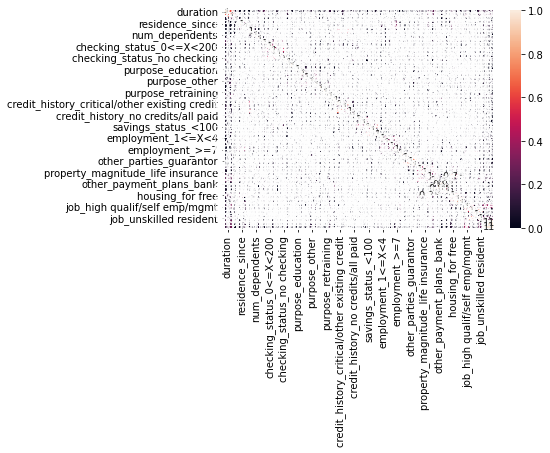

,duration,credit_amount,installment_commitment,personal_status,residence_since,age,existing_credits,num_dependents,foreign_worker,class,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,male single,4,67,2,1,1,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,female div/dep/mar,2,22,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,male single,3,49,1,2,1,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,male single,4,45,1,2,1,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,male single,4,53,2,2,1,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,female div/dep/mar,4,31,1,1,1,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,male div/sep,4,40,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,male single,4,38,1,1,1,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,male single,4,23,1,1,1,1,...,0,1,0,0,0,1,0,0,0,1


In [139]:
import seaborn as sns
from sklearn import datasets

def correlation_between_features(df: pd.DataFrame):
    '''
    Args:
        df: Dataframe of the features
       
    Returns:
       None
    '''

    # Descriptive stats
    display(df.describe())

    # Correlation matrix
    correlation_matrix = df.corr().abs()
    sns.heatmap(correlation_matrix, annot=True)
    plt.show()

    return

# Run simple EDA function...
correlation_between_features(df=df)

df

One major bias, particularly when we are fitting a model to a relatively low probability event, such as a default, are imbalances in the data. By definition our target occurs less than half the time.

#### Bias Alert: Imbalanced dataset

Imbalances in datasets for classification problems are a big issue. We generally need to balance the dataset to contain an equal proportion of the different classes before training (and testing). For the credit use-case, we have two classes {1,0}, meaning that ideally 50% of our samples should be class=1; and 50% class=0. If this is not the case and we have an imbalance (we do), we can balance the data by up-sampling the minority class, or down-sampling the majority class.
Let us first examine the dataset to determine whether it is in balance.

Dataset Balanced?
0    700
1    300
Name: class, dtype: int64
Imbalanced y variable!


True

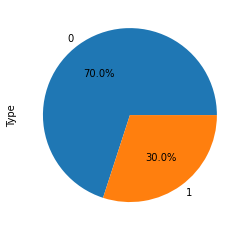

In [140]:
# Imbalanced y classes?
imbalanced_y_check(df['class'])

The dataset is not balanced. 70% of samples are class=0; only 30% are class=1. We should bring this into balance before we train our model, or risk introducing dangerous biases into our forecasts.

#### Bias Alert: Protected and Majority Groups...

Loan approval is a high risk application. We need to go very carefully as a result. We need to identify any protected characteristics (ie it would be illegal to differentiate based on these) present in the dataset. 
Our use-case is a loan approval use case, ethnicity and gender are protected charcteristics where biases would be illegal. We clearly need to remove these features.
It is also possible to identify majority groups and monitor and control for  biases in our model based on these characterictics. 


In [141]:
# Check for biases on protected characteristics...
df_female = df_raw[(df_raw['personal_status'].str.contains('female') != 0)]
df_male = df_raw[(df_raw['personal_status'].str.contains('female') == 0)]

# % of females 
female_good_credits = df_female[(df_female['class'] == 'good')].shape[0]
female_good_credits_pct = female_good_credits / df_female.shape[0]
#
male_good_credits = df_male[(df_male['class'] == 'good')].shape[0] 
male_good_credits_pct = male_good_credits / df_male.shape[0]

#  Difference in good credits for females and males...
print('Female good credits: ' + str(format(round(female_good_credits_pct*100, 2))) + '%')
print('Male good credits: ' + str(format(round(male_good_credits_pct*100, 2))) + '%')


Female good credits: 64.84%
Male good credits: 72.32%


Having found some protected characteristics and potential biases, we need to refine the dataset to consider these. 

In [142]:
# Protected characteristics - 'personal_status' has a "gender" classifier - We need to remove this from model training.
df['gender'] = np.where(df['personal_status'].str.contains('female') == 0, 1, 0) #'male'=0; female=1
df = df.drop('personal_status', axis=1)

# Another protected characteristic is age. We can categorise the ages in our dataset... 
df['age'] = df['age'].apply(lambda x: 3 if x > 65 else (2 if x > 25 else 1))

# **********************************************************
# We need to remove these columns from model training, or risk 
# illegal biases in our outcomes... 
# Keep a record of the protected columns
protected_cols = ['gender', 'age']
# **********************************************************

# Stage3: Model Design 

Now we need to take what we have learned about the data, and find an appropriate model to achieve our KPIs.

## Stage 3a: Test the performance of different up, and down sampling approaches

Before we start up or down-sampling to correct the imbalance, we first we need to create our testing and training datasets. We can then balance the training set. This is to keep the training-set in-sample and the testing-set strictly out-of-sample. There is a risk of data leakage in this process we must consider and contriol for.

#### Bias Alert: Data Leakage 

Separate training and testing datasets BEFORE balancing the dataset is crucial to avoid adta leakage. This is crucial as our learner must not see any of the test samples until we actually test it for performance. If we fail to separate testing and training data before up samplng, we can suffer data-snooping biases (also called data-leakage), which would invalidate our model.

In [143]:
from sklearn.model_selection import train_test_split

In [144]:
# Define X and y variables
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

#Test and train set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#****************************
# Keep record of protected for bias testing later
X_train_protected = X_train[protected_cols]
X_test_protected = X_test[protected_cols]

# Remember to remove protected columns before training
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

### Stage Test up and down sampling approaches using a Random Forest Classifier
We will use the RandomForest classifier to help us test different up and down sampling approaches to deal with the imbalanced dataset. We will be able to see the relative performance of each balancing approach on our problem.

First let us run the classifier on the imbalanced data and examine the F1 score that results when we test the model. (It is a very poor result).

Get the sklearn packages we will need for our clasification problem

In [145]:
import numpy as np

from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier

# metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

We can wrap training for the Random Forest classifier, and the printing of performance metrics in a function, as we will be running this more than once.

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8129, test:  0.7733
Precision train: 0.7921, test:  0.7732
Recall train: 0.9897, test:  0.9674
F1 train: 0.5761, test:  0.4138


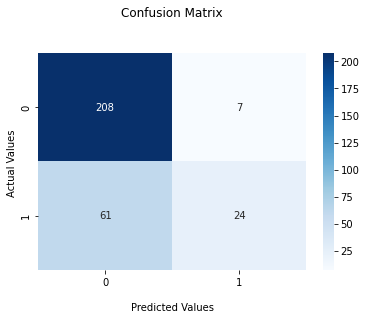

Now use sklearns predict_proba to generate probability values for each prediction


X has feature names, but RandomForestClassifier was fitted without feature names


array([[0.59765312, 0.40234688],
       [0.5879846 , 0.4120154 ],
       [0.39922466, 0.60077534],
       [0.57050746, 0.42949254],
       [0.43980588, 0.56019412],
       [0.58744188, 0.41255812],
       [0.30807259, 0.69192741],
       [0.35832384, 0.64167616],
       [0.64968884, 0.35031116]])

In [146]:
# Declare a function to wrap training of a classifier and printing of performance data
def run_rf_classification_models(X_train: pd.DataFrame, 
                              X_test: pd.DataFrame, 
                              y_train: pd.DataFrame, 
                              y_test: pd.DataFrame) -> object:
    
    '''
    Args:
      X_train: DataFrame with training data for classifier, columns are features, rows are instances
      X_test: Test data matching above shape
      y_train: training data target variable {1,0}, instances are rows.
      y_test: test data target variable {1,0}, instances are rows.
       
    Returns:
       rf: sklearn model object
       
    Author:
       Dan Philps
    '''

    #sanity
    if X_train.shape[0] != y_train.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if X_test.shape[0] != y_test.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if (X_train.dtypes != X_test.dtypes).sum() != 0:
      raise TypeError('Bad parameter: X_train.dtype != X_test.dtype')
    if (y_train.dtypes != y_test.dtypes):
      raise TypeError('Bad parameter: y_train.dtype != y_test.dtype')

    # Scale and transform the data for training
    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.fit_transform(X_train) # scale both sets:
    X_test = sclr.fit_transform(X_test)

    # classifier train
    rf = RandomForestClassifier(max_depth=5,random_state=0)
    rf.fit(X_train,y_train)
    y_train_hat =rf.predict(X_train)
    y_test_hat = rf.predict(X_test)

    # Print score
    print(type(rf))        
    print(f"Accuracy train: {rf.score(X_train,y_train):.4f}, test: ",
      f"{rf.score(X_test,y_test):.4f}")
    print(f"Precision train: {precision_score(y_train, y_train_hat, average=None)[0]:.4f}, test: ",
      f"{precision_score(y_test,y_test_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_train, y_train_hat, average=None)[0]:.4f}, test: ",
      f"{recall_score(y_test,y_test_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_train, y_train_hat, average=None)[1]:.4f}, test: ",
      f"{f1_score(y_test,y_test_hat, average=None)[1]:.4f}")
    
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_test, y_test_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()

    #sanity
    if rf is None:
      raise TypeError('Bad return: rf is None')

    return rf

#run our classifier function
mod = run_rf_classification_models(X_train, X_test, y_train, y_test)

print('Now use sklearns predict_proba to generate probability values for each prediction')
mod.predict_proba(X_test)[0:9,:]

### 3a i) Upsampling using resampling

First we test up-sampling using sklearn's resample, and examine how well it does using the RandomForest classifier. Resampling can up-sample by simply randomly selecting and copying existing observations of the minority class. We can balance the classes in this way.

In [147]:
from sklearn.utils import resample

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Create up-sampled data set for minority class
# note that n_samples= the number of samples the imbalance represents.
X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=(X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0]),
                                        random_state=None)

#****************************
# Keep record of protected for bias testing later
X_upsampled_protected = X_upsampled[protected_cols]
X_train_protected = X_train[protected_cols]
X_test_protected = X_test[protected_cols]

# Remember to remove protected columns before training
X_upsampled = X_upsampled.drop(protected_cols, axis=1)
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

#Combine train with upsampled
X_upsampled = X_train.append(X_upsampled)
y_upsampled = y_train.append(y_upsampled)

Let us check everything is in balance now

Dataset Balanced?
0    502
1    502
Name: class, dtype: int64


False

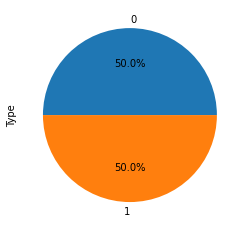

In [148]:
# Imbalanced y classes?
temp = pd.concat([X_upsampled, y_upsampled], axis=1)
imbalanced_y_check(temp['class'])

Dataset is perfectly in balance...

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8167, test:  0.7467
Precision train: 0.8412, test:  0.8466
Recall train: 0.7809, test:  0.7525
F1 train: 0.8231, test:  0.6637


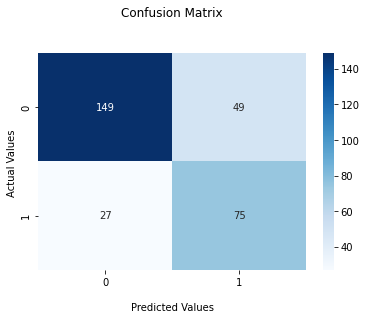

In [149]:
#Run our function....
model = run_rf_classification_models(X_upsampled, X_test, y_upsampled, y_test)

The F1 score on the test data has increased markedly.

### 3a ii) Up-sampling using a synthetic over sampling approach called SMOTE

Add the libraries we will need... and generate the synthetic data to balance our classes using SMOTE.

In [150]:
from imblearn.over_sampling import SMOTE

#How many samples do we need to balance?
idx = np.random.choice(X_train.shape[0], size=X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0], replace=False)

# Generate SMOTE samples and use this to train
upsampler_smote = SMOTE()
X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X=X_train, y=y_train)

In [151]:
X_train

,duration,credit_amount,installment_commitment,residence_since,existing_credits,num_dependents,foreign_worker,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
797,12,1258,2,4,2,1,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
351,9,959,1,2,1,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
768,12,3617,1,4,3,1,1,1,0,0,...,0,0,0,1,0,1,0,0,0,1
321,24,1938,4,3,1,1,1,0,1,0,...,0,0,1,0,0,1,0,0,1,0
161,18,1055,4,1,2,1,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,12,983,1,4,1,1,1,1,0,0,...,0,0,0,1,0,0,0,1,1,0
360,18,1239,4,4,1,1,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0
965,30,1715,4,1,1,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
491,27,8318,2,4,2,1,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1


Before we use the up-sampled dataset to train our classifier, let us first examine the distribution of the synthetic datapoints that SMOTE creates

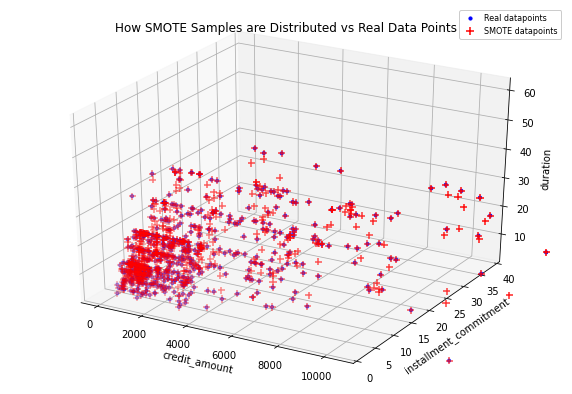

In [152]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train['credit_amount'],X_train['installment_commitment'], X_train['duration'], marker="o", s=10, c='blue', label='Real datapoints')
ax.scatter(X_upsampled_smote['credit_amount'],X_upsampled_smote['installment_commitment'], X_upsampled_smote['duration'], marker="+", s=50, c='red', label='SMOTE datapoints')

# set axes range
plt.xlim(-500, 11000)
plt.ylim(0, 40)

ax.set_xlabel('credit_amount')
ax.set_ylabel('installment_commitment')
ax.set_zlabel('duration')

plt.title('How SMOTE Samples are Distributed vs Real Data Points')
plt.legend(loc=1,framealpha=1, fontsize=8)
plt.show()

The synthetic datapoints look realistic at a glance.

Dataset Balanced?
0    502
1    502
Name: class, dtype: int64


False

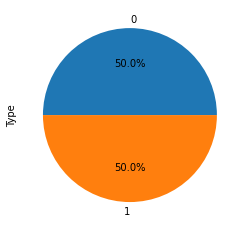

In [153]:
# Imbalanced y classes?
temp = pd.concat([X_upsampled_smote, y_upsampled_smote], axis=1)
imbalanced_y_check(temp['class'])

After up-sampling using SMOTE's synthetic data, the dataset is perfectly in balance... however we have a Fairness problem. Can you spot what it is?

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8625, test:  0.7367
Precision train: 0.8840, test:  0.8020
Recall train: 0.8347, test:  0.7980
F1 train: 0.8663, test:  0.6146


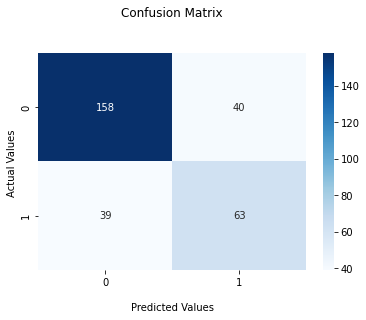

In [154]:
#Run our function....
model = run_rf_classification_models(X_upsampled_smote, X_test, y_upsampled_smote, y_test)

### 3a iii) Down-sampling - Removing rows to balance the classes

Now we can test down-sampling, which is simply removing samples from the majority class. 

In [155]:
from imblearn.under_sampling import RandomUnderSampler 

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#****************************
# Keep record of protected for bias testing later
X_train_protected = X_train[protected_cols]
X_test_protected = X_test[protected_cols]

# Remember to remove protected columns before training
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************

# Randomly downsample rows in the majority class
rus = RandomUnderSampler(random_state=42)
X_downsampled, y_downsampled = rus.fit_resample(X_train, y_train)

Dataset Balanced?
0    211
1    211
Name: class, dtype: int64


False

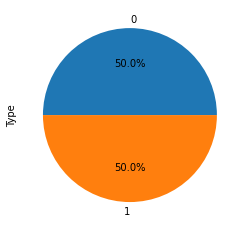

In [156]:
# Imbalanced y classes?
temp = pd.concat([X_downsampled, y_downsampled], axis=1)
imbalanced_y_check(temp['class'])

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8294, test:  0.7300
Precision train: 0.8492, test:  0.8693
Recall train: 0.8009, test:  0.7251
F1 train: 0.8341, test:  0.6197


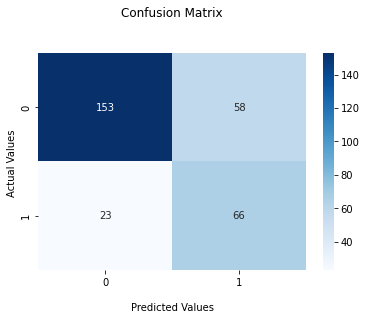

In [157]:
# Run our function to train a rf classifier....
model = run_rf_classification_models(X_downsampled, X_test, y_downsampled, y_test)

As we can see, all up and down sampling approaches have outperformed the F1 Score on the imbalanced data. The most impressive performance in this case is from up-sampling using SMOTE synthetic data.

## Stage 3b: Model Selection


Next we need to select the type of classifier we are going to use to model our problem and separate good from bad credits. We could just make a heuristic selection, but we are likely to be biased in making this selection. 

#### Bias Alert: Availability Heuristic
For instance,  is our quant team overpopulated by linear regression experts? Do we have a greater level of familiarity for Random Forest classifiers?

One way of dealing with this is to use of develop a model selection approach. We can test the problem, using many different classsifiers and assess the performance of exach based on our KPIs. However, we must be careful as even this more exhaustive approach is also open to biases. For instance if we are selection models based on p-values, we would suffer from multiplicity bias where testing multiple approaches would exaggerate the significance of a success. 

#### Bias Alert: Multiplicity bias

To control for this we would use a measure such as F1-score, and we would test this on test samples not used for training.



In [158]:
# Get cross-validation set, broken out from training data, to select the classifier
# objective is to keep the classifier choice in sample, so that running on the test data 
# will be a true out-of-sample test. No data leakage bias.

# Test and train set    
X_train_cv, X_cv, y_train_cv, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=None)

# Cross validation as a subset of 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#****************************
# Remember to remove protected columns before training
X_train = X_train.drop(protected_cols, axis=1)
X_test = X_test.drop(protected_cols, axis=1)
#****************************


Sklean provides many different classifiers and we will be testing a wide range to determine their accuracy on our problem.

In [159]:
from sklearn.preprocessing import StandardScaler

# Classsifiers from sklearn
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier

# Performance metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

To address the availability heuristic we will now build a function that tests a number of different classifiers on our problem, and the one with the best accuracy on the cross-validation data, we will select as the "best".

DecisionTreeClassifier(max_depth=5)
F1 train: 0.8006, cross-validation:  0.3836
GaussianNB()
F1 train: 0.8302, cross-validation:  0.1389
LogisticRegression(max_iter=2000, random_state=0)
F1 train: 0.8373, cross-validation:  0.5131
MLPClassifier(early_stopping=True, max_iter=2000, random_state=1)
F1 train: 0.7129, cross-validation:  0.4371
RandomForestClassifier(max_depth=3, random_state=0)
F1 train: 0.8288, cross-validation:  0.4800
LinearDiscriminantAnalysis()
F1 train: 0.8444, cross-validation:  0.4860
QuadraticDiscriminantAnalysis()
F1 train: 0.7239, cross-validation:  0.4615


Variables are collinear


AdaBoostClassifier()
F1 train: 0.8366, cross-validation:  0.0000
GradientBoostingClassifier()
F1 train: 0.9455, cross-validation:  0.0312
KNeighborsClassifier(n_neighbors=3)
F1 train: 0.8249, cross-validation:  0.0000
SVC(C=0.025, probability=True)
F1 train: 0.3617, cross-validation:  0.0000
NuSVC(probability=True)
F1 train: 0.3013, cross-validation:  0.4615

Winner
 <class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy train: 0.8216, cross-validation:  0.5571
Precision train: 0.8232, cross-validation:  0.8293
Recall train: 0.8713, cross-validation:  0.4626
F1 train: 0.8373, cross-validation:  0.5131


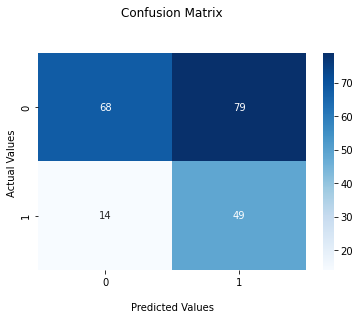

In [160]:

# Func to wrap up running these selected classification learners...
# NOTE: to test the performance of the learners out-of-sample, we should use a cross-validation dataset
# this is a hold back dataset and we will use our testing data to do this, in this case. 
def auto_classifier_selection(X_train: pd.DataFrame, 
                            X_cross_validation: pd.DataFrame, 
                            y_train: pd.DataFrame, 
                            y_cross_validation: pd.DataFrame) -> (object, list, list, list):
    
    '''
    Args:
      X_train: DataFrame with training data for classifier, columns are features, rows are instances
      X_cross_validation: cross validation data matching above shape, used in model selection
      y_train: training data target variable {1,0}, instances are rows.
      y_cross_validation: test data target variable {1,0}, instances are rows, used in model selection
       
    Returns:
       max_mdl: sklearn model object performing "best"
       all_mdls: list of sklearn classifier objects trained
       all_mdls_desc: list of description of the above model objects (elements corresponding to the above also)
       all_mdls_prec: list of precision scores of the above model objects (elements corresponding to the above also)
       
    Author:
       Dan Philps
    '''
    #sanity
    if X_train.shape[0] != y_train.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if X_cross_validation.shape[0] != y_cross_validation.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if (X_train.dtypes != X_cross_validation.dtypes).sum() != 0:
      raise TypeError('Bad parameter: X_train.dtype != X_cross_validation.dtype')
    if (y_train.dtypes != y_cross_validation.dtypes):
      raise TypeError('Bad parameter: y_train.dtype != y_cross_validation.dtype')

    #Balance training data....
    # Generate SMOTE samples and use this to train
    upsampler_smote = SMOTE()
    X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train.values, y_train.values)

    sclr = StandardScaler()
    sclr.fit(X_train.values) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.fit_transform(X_upsampled_smote) # scale both sets:
    X_cross_validation = sclr.fit_transform(X_cross_validation)
    
    # These are the classifiers we will select from...
    dtc = DecisionTreeClassifier(max_depth=5) #If we allow endless depth we overfit
    gnb = GaussianNB()
    lr = LogisticRegression(max_iter=2000,random_state=0)
    mlp = MLPClassifier(max_iter=2000,random_state=1, early_stopping=True) # MLP will tend to overfit unless we stop early   
    rf = RandomForestClassifier(max_depth=3,random_state=0) # << artibitrary parameters, consider hyper parameter tuning.
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    ada = AdaBoostClassifier()
    gbc = GradientBoostingClassifier()
    knn = KNeighborsClassifier(n_neighbors=3) # << artibitrary parameters, consider hyper parameter tuning.
    svc = SVC(kernel="rbf", C=0.025, probability=True) # << artibitrary parameters, consider hyper parameter tuning.
    nsvc = NuSVC(probability=True)
    
    all_mdls = [dtc, gnb, lr, mlp, rf, lda, qda, ada, gbc, knn, svc, nsvc]
    all_mdls_desc = ['dtc', 'gnb', 'lr', 'mlp', 'rf', 'lda', 'qda', 'ada', 'gbc', 'knn', 'svc', 'nsvc']
    all_mdls_prec = []
    
    # Loop through each classifer and record the "best"...
    max_prec = 0
    for mdl in all_mdls:
        #Fit model
        mdl.fit(X_upsampled_smote,y_upsampled_smote)  
        y_train_hat = mdl.predict(X_upsampled_smote)
        y_cross_validation_hat = mdl.predict(X_cross_validation)       
        mdl.predict_proba(X_cross_validation)

        # Output model selection information....
        print(mdl)
        print(f"Precision train: {precision_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, cross-validation: ",
        f"{precision_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}")
  
        # Selection based on cross-validation set, ie out of sample data not used in training
        this_cv_prec = precision_score(y_cross_validation,y_cross_validation_hat, average=None)[1]
        if this_cv_prec > max_prec:
            max_prec = this_cv_prec
            max_mdl = mdl
        
        #Save the F1 score of this model...
        all_mdls_prec.append(this_cv_prec)

    # The best....
    #Fit...
    max_mdl.fit(X_upsampled_smote,y_upsampled_smote)
    y_train_hat = max_mdl.predict(X_upsampled_smote)
    y_cross_validation_hat = max_mdl.predict(X_cross_validation)
    
    #    Print score
    print('\nWinner\n', type(max_mdl))        
    print(f"Accuracy train: {max_mdl.score(X_train,y_upsampled_smote):.4f}, cross-validation: ",
      f"{max_mdl.score(X_cross_validation,y_cross_validation):.4f}")
    print(f"Precision train: {precision_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, cross-validation: ",
      f"{precision_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, cross-validation: ",
      f"{recall_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, cross-validation: ",
      f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}")
        
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_cross_validation, y_cross_validation_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float')

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()
    
    #sanity
    if max_mdl is None:
      raise TypeError('Bad return: max_mdl is None')

    return max_mdl, all_mdls, all_mdls_desc, all_mdls_prec

# Run our function....autoselect the best classifier wrt F1
max_mdl, all_models, all_models_desc, all_mdls_prec = auto_classifier_selection(X_train_cv, X_cv, y_train_cv, y_cv)


The output from our model selection function shows how each classifier performed on the training and cross-validation datasets. We can now test the "winning classifier" on our test data to ensure the cross-validation tests were effective in selecting a good performance out of sample.

0.6301369863013698


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
X has feature names, but LogisticRegression was fitted without feature names


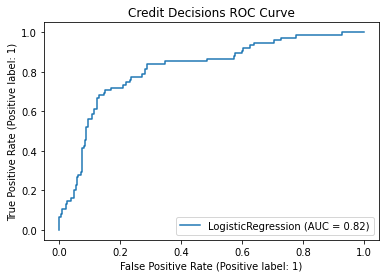

0.6216216216216216 0.6301369863013698 0.6133333333333333


In [161]:
# Predict
y_test_hat = max_mdl.predict(X_test.values)

# Analyst KPI...
f1, prec, rec = kpi_review_analyst(mdl=max_mdl,X=X_test, y=y_test[:].values, y_hat=y_test_hat[:])
print(f1, prec, rec)

#### Bias Alert: Inductive bias

Even in the case where we select the most appropriate model, we may still be exposed to inductive biases. Each learner has a specific way that will approximate the function we are attempting to approximate, in this cadse the function of credit quality based on the characteristics of borrowers. Decision Trees, for instance, have inductive biases associated with greedy separation, whereas Random Forests (RF) mitigate this bias by using many randomized decision trees, but in turn introduce (lesser) inductive biases associated with the way an RF's underlying decision trees are contructed. One mitigant is to ensemble different learners, using a soft-max function or a voting approach. For voting based ensembling we would simply run a number of classifiers, take the majority answer: good/bad credit. (Note that we have included 


Variables are collinear
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
X has feature names, but NuSVC was fitted without feature names
Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


0.6086956521739131


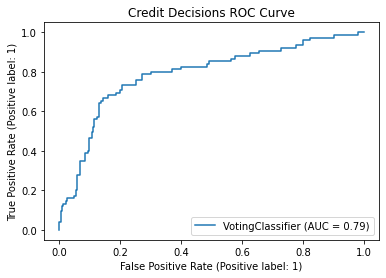

0.5833333333333334 0.6086956521739131 0.56


In [162]:

# Run the challenger ensemble
y_test_hat, ens_mdl = challenger_ensemble_run(all_mdls=all_models,
                        all_mdls_desc=all_models_desc,
                        all_mdls_prec=all_mdls_prec,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test)

# Analyst KPI...
f1, prec, rec = kpi_review_analyst(mdl=ens_mdl,X=X_test.values, y=y_test[:].values, y_hat=y_test_hat[:])
print(f1, prec, rec)

### DRAFT!!!! FAIRNESS FUNCTIONS Removing features correlated with protected characteristics

Let us inspect the results between the "fair" model outcomes and the potentially biased....

## Stage 3c: Fairness

We need to ensure that accuracy is similar across different population groups, in other words that there is no unfairness in model outcomes that can be linked to these groups. To do this we use the utilities weintroduced earlier in the notebook.

We need to examine recall to ensure fairness (a customer KPI) and precision (a business KPI) to ensure we have an acceptable false positive rate. For the fairness tests we will look at different population groups: gender(Male/Female) and Age Group (Below 25/25-60/Above 60 age groups. In a fair model, each of the population groups should not be more than 20% worse-off than the majority group. 
The plots display the range as between the two red lines. Any population group with a metric value outside the range between the red lines is impacted negatively by the model. Adjusting the model parameters or

Higher the recall values, the lower is the False Negatives. Higher the precision values, the lower is False Positives. A judgement call is neeeded to confirm if the false positives have more adverse impact or false negatives. In case of credit approval process, for a loan applicant, false negatives should be minimized. So recall is the more appropriate measure.

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
Madhu... Fairness applied to the chosen model....
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

# Stage4: Model Deployment 

Model deployment generally involves a change process, several levels of testing and sign off, asignment of responsibilities for the live operation of the process, models and data before deployiong the code to the cloud (or on native hardware). 
A key part of thius stage is communication of the KPIs to stakleholders to enable them to understand the way the models operate, the risks involved and to be accountable for deploying the models


## Stage4a. KPIs

## Stage4b. Communication: Stakeholder Oriented Explanations

Communication of how the model has reached the outcomes it is has, is crutial to achieve fairness, transparency, accountability, and trust in the whole process. Each stakeholder in the process needs to see different elements. The Data Scientist and technical leadership need to review the nut and bolts of the model, reviewing residuals plots, parameter importance, interaction terms and many other metrics. The customer needs to see far less information, and mainly that associated with a refusal of credit. Compliance resources and regulators need to see something different again, such as fairness regarding protected characteristics, the accuracy and therefore capital risk represented by the models. 
In this section we look at stakeholder oriented explanations and we will be using standard charts of important analytics, such as residual plots, and SHAP.

First let us get the packages we will need...

In [163]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [164]:
import shap

Now instantiate the SHAP explainer object for our classifier and generate Shapley values for the test data... Note that as we will be using the test data, all the analysis is therefore based on the out of sample performance of our model.

In [165]:
print(type(max_mdl).__name__)

# Instantiate an explainer object for our chosen classifier...
if type(max_mdl).__name__ == 'DecisionTreeClassifier':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'GaussianNB':
  explainer = shap.KernelExplainer(max_mdl.predict, X_test.values)
  shap_values = explainer.shap_values(X_test.values)
elif type(max_mdl).__name__ == 'LogisticRegression':
  explainer = shap.explainers.Permutation(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'MLPClassifier':
  explainer = shap.KernelExplainer(max_mdl.predict, X_test.values)
  shap_values = explainer.shap_values(X_test.values)
elif type(max_mdl).__name__ == 'RandomForestClassifier':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'LinearDiscriminantAnalysis':
  masker = shap.maskers.Independent(data = X_test.values)
  explainer = shap.LinearExplainer(max_mdl, masker = masker)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'QuadraticDiscriminantAnalysis':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'AdaBoostClassifier':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'GradientBoostingClassifier':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'KNeighborsClassifier':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'SVC':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'NuSVC':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)


LogisticRegression


### 1) Analyst and technical explainability

0.6086956521739131


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
X has feature names, but LogisticRegression was fitted without feature names


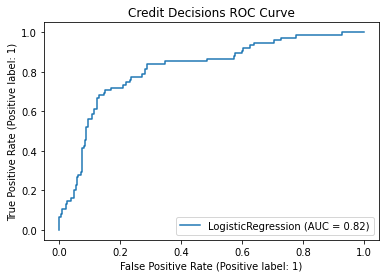

(0.5833333333333334, 0.6086956521739131, 0.56)

In [166]:
# Analyst KPI...
kpi_review_analyst(mdl=max_mdl,X=X_test, y=y_test, y_hat=y_test_hat)

In [167]:
X_test

,duration,credit_amount,installment_commitment,residence_since,existing_credits,num_dependents,foreign_worker,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
109,14,1410,1,2,1,1,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
446,36,1842,4,4,1,1,1,0,1,0,...,0,0,1,0,0,1,0,0,0,1
773,24,2223,4,4,2,1,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
756,6,1299,1,1,3,2,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
20,9,2134,4,4,3,1,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,24,5804,4,2,2,1,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
139,12,1881,2,2,1,1,1,0,0,1,...,0,0,0,1,0,0,0,1,0,1
230,36,4210,4,2,1,1,1,0,0,1,...,0,0,1,0,0,1,0,0,1,0
804,12,7472,1,2,1,1,1,1,0,0,...,0,0,0,1,0,0,1,0,1,0


Feature importance

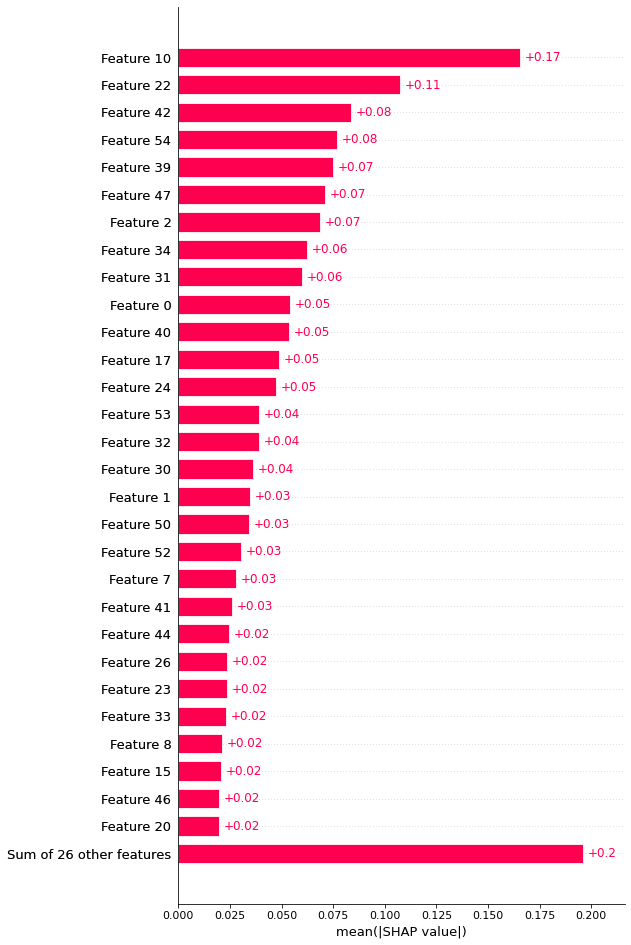

In [168]:
# Plot the feature importance
shap.plots.bar(shap_values=shap_values, max_display=30)

Beeswarm plot, showing features ranking by importance, and the impact of each instance passed to the shap explainer. Note the feature value is color coded from "high" to "low" (vertical axis), and the Shap value represents the impact on the model output of the value (horixontal axis). 

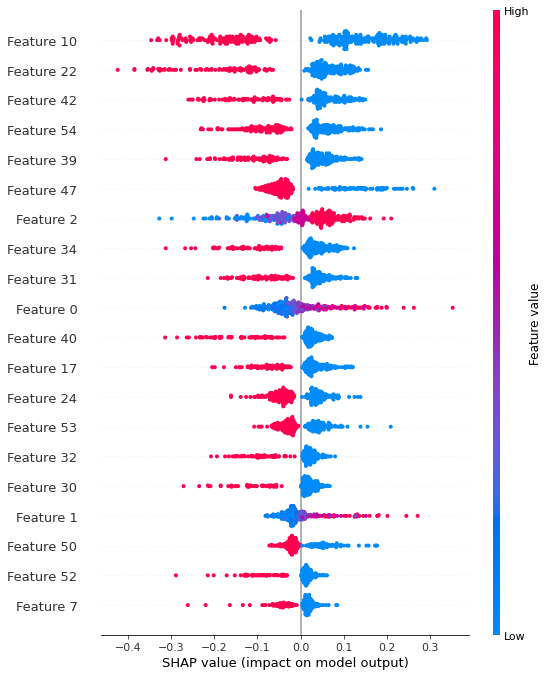

In [169]:
shap.summary_plot(shap_values)

### 2) Compliance and Regulatory



See if any features are suspiciously important for one gender vs another.

In [170]:
X['gender']

0      1
1      0
2      1
3      1
4      1
      ..
995    0
996    1
997    1
998    1
999    1
Name: gender, Length: 1000, dtype: int64

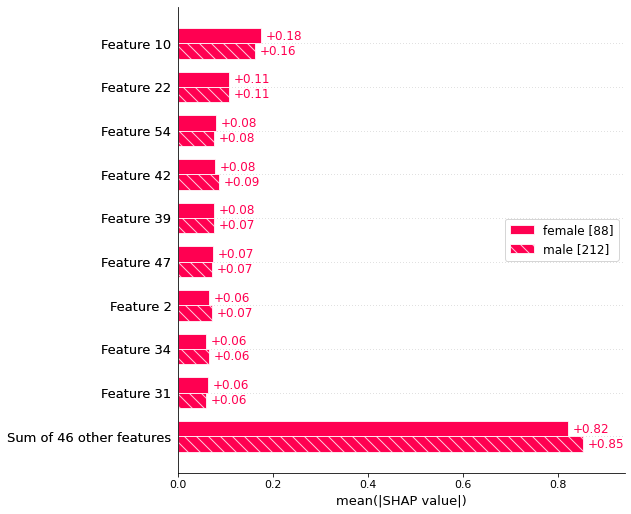

In [171]:
# Parameter importance by gender..
gdr = ["male" if x==1 else "female" for x in X_test_protected['gender']]

# Plot the feature importance
shap.plots.bar(shap_values.cohorts(gdr).abs.mean(0))

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
Madhu
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

### 3) Customer

A customer may want to knowlt he sensitivity of the decision to certain characteristics. IF a refusal has been made, it would be beneficial to report to the customer what they need to change to get a favorable outcome. 

We can use the SHAP waterfall plot to help

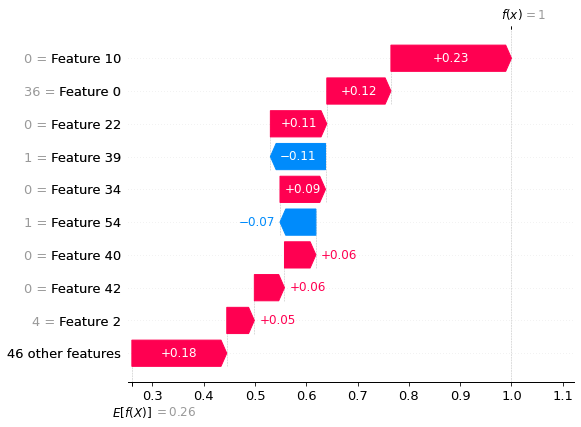

In [172]:
# Find a customer with bad credit prediction
for rejected_eg_rowno in range(0,y_test.shape[0]):
  if y_test.iloc[rejected_eg_rowno] == 1:
    break

# This customer was refused credit and we can provide an explanation for their refusal...
shap.plots.waterfall(shap_values[rejected_eg_rowno])

In [173]:
y_test.reset_index()

,index,class
0,109,0
1,446,1
2,773,0
3,756,0
4,20,0
...,...,...
295,860,0
296,139,0
297,230,1
298,804,0


# Stage 5: Model Monitoring and Reporting

Our model is now in production and being used in practice. We are "risk on" and we need to continually monitor and record our KPIs. Individuals accountability for these processes is critical.

We also need to monitor data drift. If the distribution or the nature of the data we pass into our model substantioally differs from our training data, our model results will almost certainly be garbage. We need to monitor data drift and should drift occurr we need to re-run our model developmnent process to traing an appropriate model. This would take us back to Stage2 in this process.

There is also the question of whether our model is still the best approach as time steps forward? Our model paramaters may become stale, the model itself may be less appropriaytr given its inductive biases. Many things can change and to monitor this we should consider using a challenger model. Challenger models are used to compete against our live model, and we should monitor our KPIs generated by our live model and compare them to those produced by the challenger model. 

## Stage5a: Data Drift

In [174]:
# AUGUSTINE! Add your function call HERE

## Stage5b: Challenger Models

So what model do we use as a challenger, and when do we traing it? There are no perfect answers but we can use our model development pipeline to help. Note that our model selection function, auto_classifier_selection, allowed us to generate a range of classifiers, we can use one or all of these classifiers as our challenger. If we decided to ensemble the classifiers as our live model (ir combine the results of all in a voting ensemble for instance) we can select the best single model as our challeger. If we decided to use the best single model as our live model, we can use a boting ensemble as our challenger.



In [178]:
# Run the challenger ensemble
y_test_hat, ens_mdl = challenger_ensemble_run(all_mdls=all_models,
                        all_mdls_desc=all_models_desc,
                        all_mdls_prec=all_mdls_prec,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test)


NameError: ignored